In [1]:
import os
from osgeo import gdal
import numpy as np
import cv2

In [2]:
# LOAD Rasterized ground truth shapefile
mask = np.load('AllCropArray.npy')
index1 = np.where(mask==1)
index2 = np.where(mask==2)
index3 = np.where(mask==3)
index4 = np.where(mask==4)
mask_pixel = len(np.nonzero(mask)[0])
print(mask_pixel)

## Utils function


In [52]:
def read_img(date,band):
    base_dir = r"D:\Hackathon\Varuna Hackathon 2022\sentinel-2 image\2021"
    folder = 'IMG_DATA'
    img_path ='47PQS_'+date+'_'+band+'.jp2'
    read_path = os.path.join(base_dir,date,folder,img_path)
    #print(read_path)
    temp = gdal.Open(read_path)
    temp_arr = temp.GetRasterBand(1).ReadAsArray().astype('float32')
    return temp_arr
def NDVI(date):
    img4_arr=read_img(date,'B04')
    img8_arr=read_img(date,'B08')
    ndvi = (img8_arr-img4_arr)/(img8_arr+img4_arr)
    return ndvi
def SAVI(date):
    L = 0.428
    img4_arr=read_img(date,'B04')
    img8_arr=read_img(date,'B08')
    savi = (img8_arr - img4_arr) / (img8_arr + img4_arr + L) * (1.0 + L)
    return savi

## GOAL

We explore the entire image folder to select to appropiate date for classification.\
What we do in this block?
1. Find training ground truth and CLOUD overlap ratio
2. Calculate mean of NDVI to find the time period that the crop was planted

In [56]:
base_dir = r"D:\Hackathon\Varuna Hackathon 2022\sentinel-2 image\2021"
all_path = []
ndvi_mean1 = []
ndvi_mean2 = []
ndvi_mean3 = []
ndvi_mean4 = []
date_list = []

for date in os.listdir(base_dir):
    Scl_arr = read_img(date,'SCL')
    Scl_arr = cv2.resize(Scl_arr,(2051,2051))
    
    # Use SCL band to determin CLOUD pixels
    cloud_mask = ((Scl_arr==7)+(Scl_arr==8)+(Scl_arr==9)+(Scl_arr==10))*1
    
    # Calculate overlap ratio between TRAIN raster and CLOUD mask
    mask_cloud_overlap = ((mask!=0)*1)*cloud_mask
    mask_cloud_overlap_pixel = mask_cloud_overlap.sum()
    overlap_ratio = mask_cloud_overlap_pixel/mask_pixel
    
    # Select an image with overlap ration less than 20%
    if overlap_ratio < 0.2:
        print('Date:',date,"Shapefile/Cloud Overlap ratio",overlap_ratio)
        date_list.append(date)
        ndvi = NDVI(date)
        ndvi_mean1.append(ndvi[index1].mean())
        ndvi_mean2.append(ndvi[index2].mean())
        ndvi_mean3.append(ndvi[index3].mean())
        ndvi_mean4.append(ndvi[index4].mean())

Date: 20210101 Shapefile/Cloud Overlap ration 6.332266698187284e-05


C:\Users\USER\anaconda3\envs\hackathon\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Date: 20210111 Shapefile/Cloud Overlap ration 0.010228721473138525
Date: 20210116 Shapefile/Cloud Overlap ration 0.00015619591188861966
Date: 20210126 Shapefile/Cloud Overlap ration 8.44302226424971e-05
Date: 20210205 Shapefile/Cloud Overlap ration 5.065813358549826e-05
Date: 20210215 Shapefile/Cloud Overlap ration 0.004246840198917605
Date: 20210220 Shapefile/Cloud Overlap ration 0.0
Date: 20210225 Shapefile/Cloud Overlap ration 0.0020896480104018035
Date: 20210302 Shapefile/Cloud Overlap ration 0.01813561182360838
Date: 20210307 Shapefile/Cloud Overlap ration 0.0006796632922721018
Date: 20210312 Shapefile/Cloud Overlap ration 0.00023640462339899191
Date: 20210327 Shapefile/Cloud Overlap ration 0.02760446129296443
Date: 20210401 Shapefile/Cloud Overlap ration 0.06363928031678219
Date: 20210421 Shapefile/Cloud Overlap ration 0.017038018929255917
Date: 20210511 Shapefile/Cloud Overlap ration 0.05938821860673247
Date: 20210521 Shapefile/Cloud Overlap ration 0.01872662338210586
Date: 2021

# NDVI and SAVI Visualization

## Plot NDVI graph

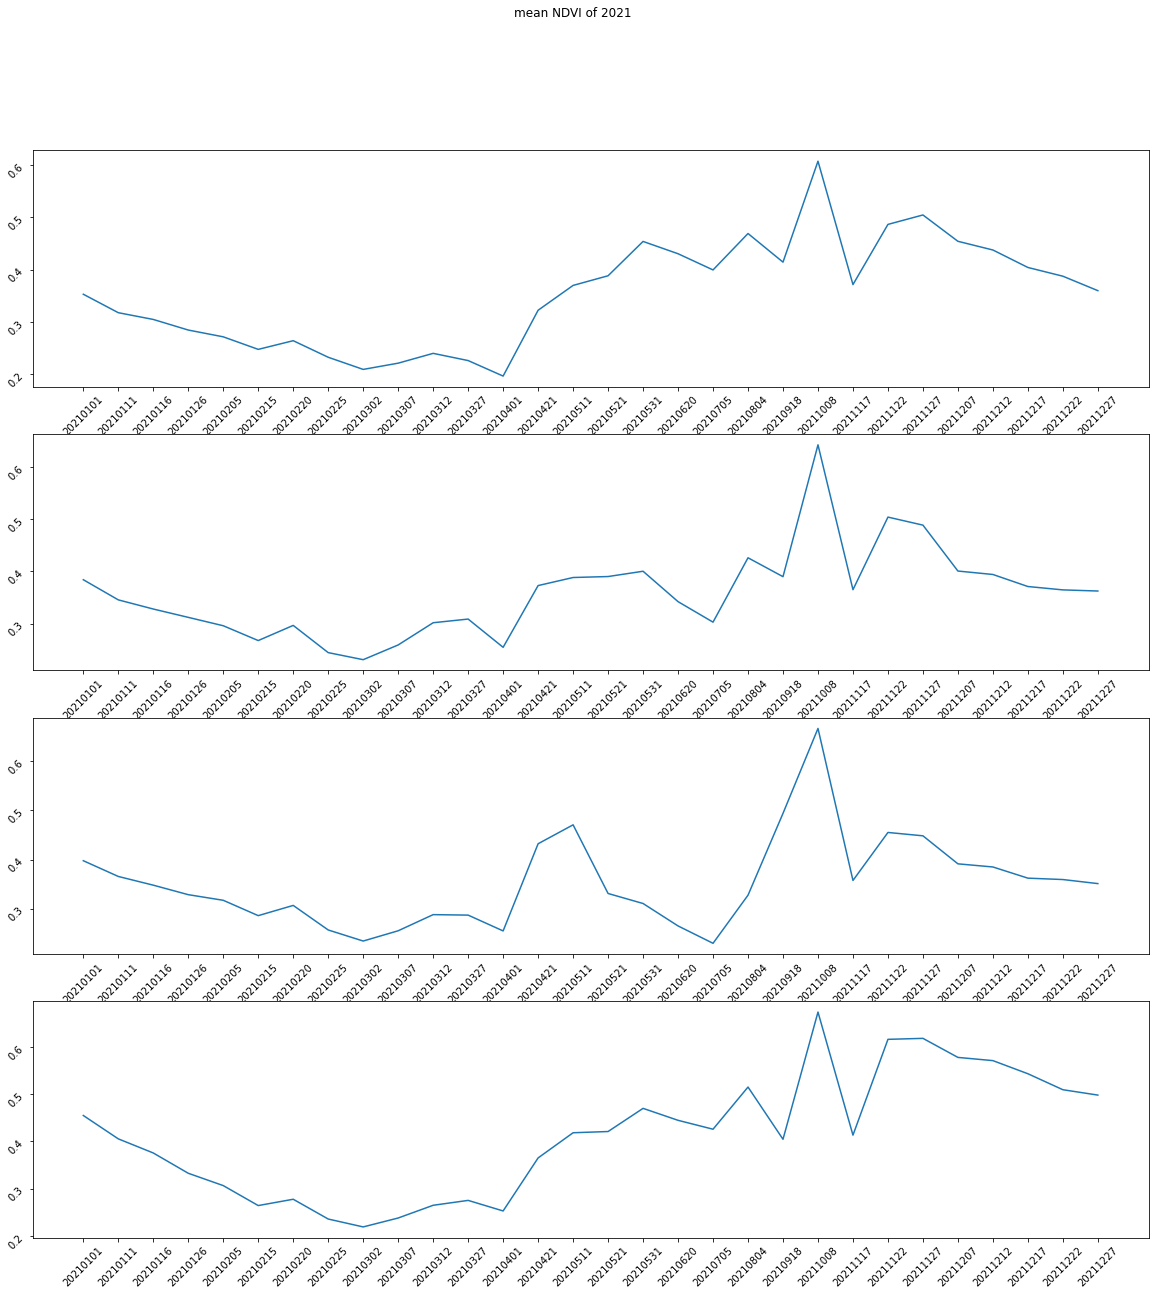

In [34]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(20,20))

fig.suptitle('mean NDVI of 2021')
ax1.plot(date_list,ndvi_mean1)
ax1.tick_params(labelrotation=45)
ax2.plot(date_list,ndvi_mean2)
ax2.tick_params(labelrotation=45)
ax3.plot(date_list,ndvi_mean3)
ax3.tick_params(labelrotation=45)
ax4.plot(date_list,ndvi_mean4)
ax4.tick_params(labelrotation=45)
plt.show()

From the NDVI graph plotted over one year, NDVI values are dropped at 2021-04-01 then increasing until end of the year.
After we examnied the trend, we decide to use 2021-04-01 as a starting date of multi-temporal data.

## Plot NDVI histrogram of each crop type

C:\Users\USER\anaconda3\envs\hackathon\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


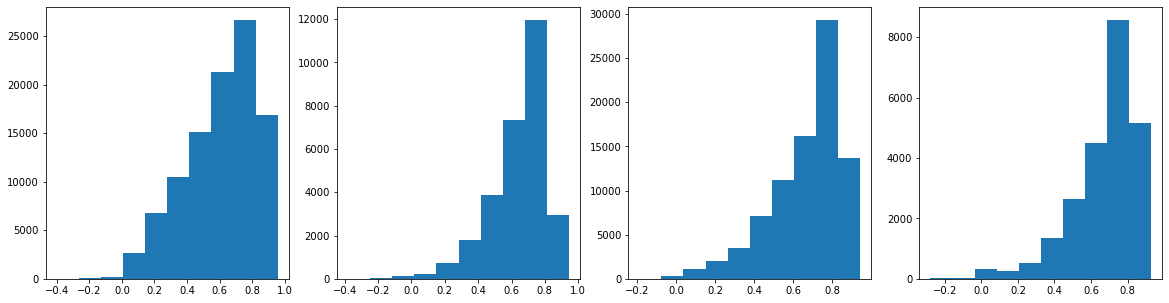

In [51]:
ndvi = NDVI('20211008')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

counts, bins = np.histogram(ndvi[index1])
ax1.hist(bins[:-1], bins, weights=counts)
counts, bins = np.histogram(ndvi[index2])
ax2.hist(bins[:-1], bins, weights=counts)
counts, bins = np.histogram(ndvi[index3])
ax3.hist(bins[:-1], bins, weights=counts)
counts, bins = np.histogram(ndvi[index4])
ax4.hist(bins[:-1], bins, weights=counts)
plt.show()

## Plot SAVI histrogram of each crop type

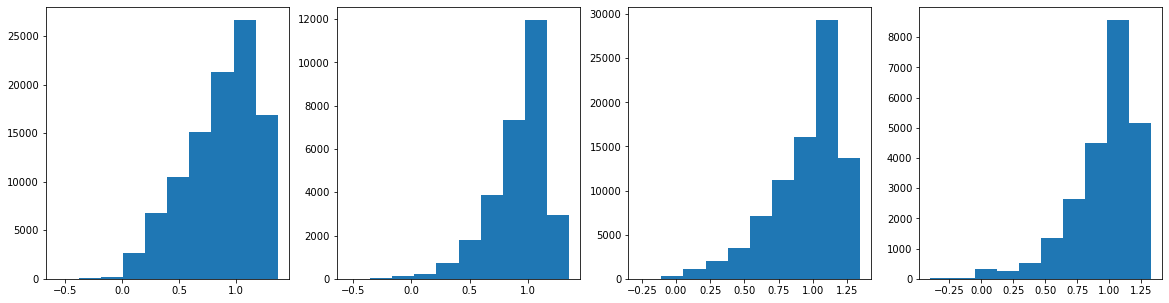

In [53]:
savi = SAVI('20211008')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))
counts, bins = np.histogram(savi[index1])
ax1.hist(bins[:-1], bins, weights=counts)
counts, bins = np.histogram(savi[index2])
ax2.hist(bins[:-1], bins, weights=counts)
counts, bins = np.histogram(savi[index3])
ax3.hist(bins[:-1], bins, weights=counts)
counts, bins = np.histogram(savi[index4])
ax4.hist(bins[:-1], bins, weights=counts)
plt.show()

As resulted in both NDVI and SAVI histrogram figure, it clearly show that the data of each crop type are distributed similarly.
Using only one band for image classification may not effective. This is the main reason why we choose to perform a classification in multi-temporal data.